# Trabalho 1 - Inventário de emissões com Python
Desenvolvedores: José Henrique Hess e Kezia Bernarda de Oliveira

In [132]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import locale
from matplotlib.ticker import FuncFormatter

## Ler planilha dos fatores de emissão e estimar a emissão com base na taxa de atividade do empreendimento.
Foi utilizado o capítulo 12.13 da AP42, pois a fundição de aço é a mais representativa da empresa WEG.
Link: https://www.epa.gov/sites/default/files/2020-11/documents/c12s13.pdf

In [133]:
# Coletando o caminho da pasta que estou
cwd = os.getcwd()

# Pasta dos fatores de emissão
path = os.path.join(cwd, 'tabelas', 'FE')

# Indicando nome do arquivo
chapterNumer = 12
subChapter = 13
file = f'chp_{chapterNumer}_{subChapter}.csv'
print(file)

# Diretório do arquivo completo
full_path = os.path.join(path, file)
print(full_path)

# Abrindo o arquivo utilizando o pandas
fe = pd.read_csv(full_path, encoding='utf-8')
print(fe)

chp_12_13.csv
C:\Users\joseh\Documents\GitHub\ENS5173_202401\tabelas\FE\chp_12_13.csv
                 Processo  Particula Filtravel  NOx  PM10
0                   Fusão                  6.5  0.1   NaN
1  Manuseio Areia (areia)                  NaN  NaN  0.27
2    Manuseio Areia (aço)                  NaN  NaN  3.00
3          Fornos (areia)                  NaN  NaN  1.11
4            Fornos (aço)                  NaN  NaN  0.45
5            Derramamento                  NaN  NaN  1.40
6                 Limpeza                  NaN  NaN  0.85
7              Tratamento                  NaN  NaN  0.18
8            Resfriamento                  NaN  NaN  0.70


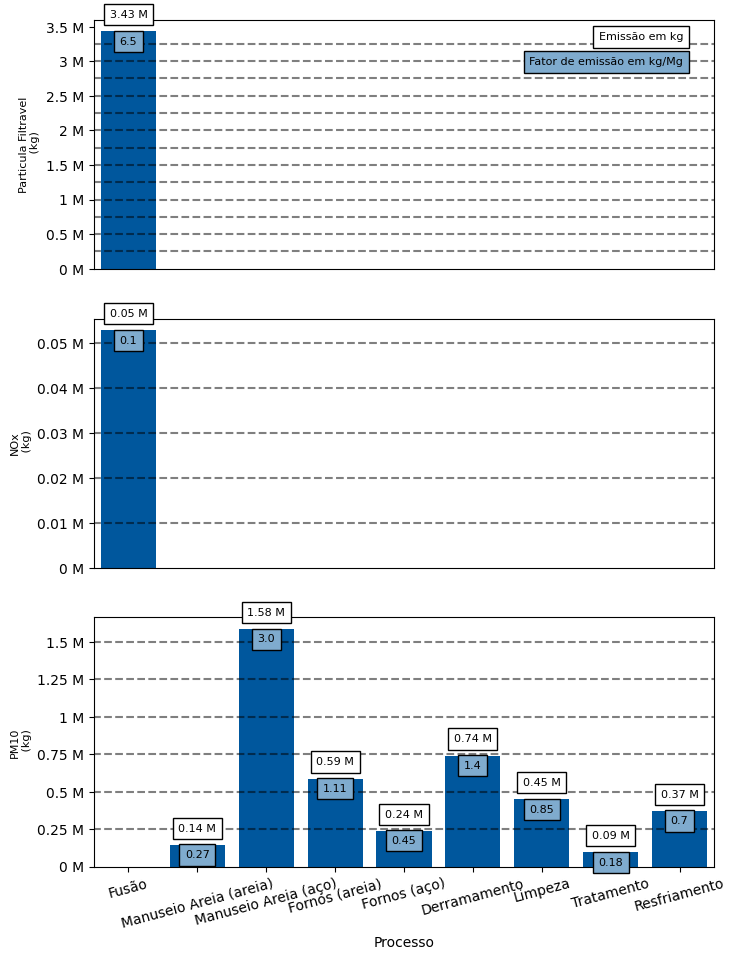

In [134]:
# Plotando os fatores de emissão

# Função para formatar os rótulos em milhões
def mil(x, pos):
    if x % 1e6 == 0:
        return '%1.0f M' % (x * 1e-6)
    elif x % 1e5 == 0:
        return '%1.1f M' % (x * 1e-6)
    else:
        return '%1.2f M' % (x * 1e-6)

# A WEG produziu cerca de 20 milhões de motores em 2023, sendo que 40% das emissões se encontram na cidade de Jaraguá do Sul
# Nesse sentido, de acordo com catálogo de motores na internet, foi atribuído 0.1 toneladas de peso médio de motor, que é aproximadamente o valor mediano encontrado dos motores https://pt.slideshare.net/PAULISTA169/catalogo-de-motores-weg
# Além disso, de acordo com inventário de emissões da empresa, o aço é responsável por 65,96 % das emissões que acontecem na fábrica https://static.weg.net/medias/downloadcenter/h5d/hb6/WEG_Inventario_GEE_2022.pdf
# Por isso, foi adotado que dos 20 milhões de motores produzidos, 40% são em Jaraguá, eles pesam 0.1 toneladas, e são compostos por 65.96% de aço
# Ressalta-se que isso são aproximações para efetuar os cálculos, seria necessária saber qual a composição verdadeira dos motores, qual a venda de cada tipo de motor, informações essas não disponíveis na internet
atv = 20000000*0.4*0.1*0.6596
# print(atv)

# Criando a figura com Matplotlib
# Subplots com número de linhas igual ao número de poluentes
# Sharex significa compartilhar eixo x
fig,ax = plt.subplots(len(fe.columns)-1,1,sharex=True,figsize=(8,11))

#Loop para preencher o subplot com os gráficos de barra
for ii in range(1,len(fe.columns)):
    barras = ax[ii-1].bar(fe['Processo'], atv * fe.iloc[:, ii], color='#00579D')
    
    # Anotando o valor de cada barra e o fator de emissão de cada barra
    for barra in barras:
        altura = barra.get_height()
        if np.isfinite(altura):  # Verificando se a altura não é nan
            i = round((barra.get_x())-0.6)+1
            # Adicionando os valores totais de emissão e de fator de emissão
            ax[ii-1].text(barra.get_x() + barra.get_width() / 2, altura + 0.05 * atv*fe.iloc[:,ii].max(), mil(altura, None),
                          ha='center', va='bottom', fontsize=8,
                          bbox=dict(facecolor='white', alpha=1, edgecolor='black'))
            ax[ii-1].text(barra.get_x() + barra.get_width() / 2, altura - 0.02 * atv*fe.iloc[:,ii].max(), fe.iloc[i, ii],
                          ha='center', va='top', fontsize=8,
                          bbox=dict(facecolor='#7FABCE', alpha=1, edgecolor='black'))

    # Explicação dos textos
    if ii == 1:
        ax[ii-1].text(0.95, 0.95, 'Emissão em kg', transform=ax[ii-1].transAxes, fontsize=8,
                      verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=1))
        ax[ii-1].text(0.95, 0.85, 'Fator de emissão em kg/Mg', transform=ax[ii-1].transAxes, fontsize=8,
                      verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='#7FABCE', alpha=1))

    # If Else para deixar o eixo x apenas no último gráfico
    if ax[2] == ax[ii-1]:
        ax[ii-1].set_xlabel('Processo')
        ax[ii-1].set_xticks(range(len(fe['Processo'])))
        ax[ii-1].set_xticklabels(fe['Processo'], rotation=15)
    else: 
        ax[ii-1].xaxis.set_visible(False)
    ax[ii-1].set_ylabel(fe.columns[ii]+'\n (kg)',fontsize=8)

    # Configura o formatter para milhões
    formatter = FuncFormatter(mil)
    ax[ii-1].yaxis.set_major_formatter(formatter)

    # Limitando o tamanho do eixo x
    ax[ii-1].set_xlim(-0.5,8.5)

    # Estabelecendo linhas pontilhadas no gráfico
    for i in range(1,int(atv*fe.iloc[:,ii].max())+1):
        if i%10000 == 0:
            if int(atv*fe.iloc[:,ii].max()) < 100000:
                ax[ii-1].hlines(y=i,xmin=-1,xmax=9, alpha=0.5,linestyle='dashed', colors = 'black')
            else: 
                if i%250000 == 0:
                    ax[ii-1].hlines(y=i,xmin=-1,xmax=9, alpha=0.5,linestyle='dashed', colors = 'black')

# Salva a figura na pasta figures - criar a pasta antes
fig.savefig(cwd+'\\figures\\barplot_fatorEmiss.png')

#### Qual é o processo do empreendimento que possui maior emissão?

Ao avaliar as figuras, percebe-se que para os poluentes partícula filtrável e NOx, o processo de fusão é o que possui maior emissão, sendo 6.5 o fator de emissão para partícula filtrável e 0.1 para o NOx, emitindo no ano 3.43 milhões de kgs e 0.05 milhões de kgs para partícula filtrável e NOx, respectivamente. Já o processo que tem maior emissão de PM10 é o manuseio de areia, de acordo com as toneladas de areias utilizada no processo, sendo que foi entendido que para cada tonelada de aço é utilizado uma tonelada de areia¹, em que o fator de emissão é 3 e a emissão é de 1.58 milhões de kgs de PM10 no ano, entretanto, se for avaliar o processo inteiro, considerando a emissão em relação ao aço também, o fator de emissão sobe para 4.11, sendo 2.17 milhões de kgs de PM10 emitidos no ano.

¹: https://repositorio.ufmg.br/bitstream/1843/BUOS-9ATFXE/1/monografia_areia_de_fundi__o.pdf (2º parágrafo da introdução)

In [135]:
# Criando vetor de datas
import pandas as pd

# Criar um intervalo de datas
datas = pd.date_range(start='2023-01-01', end='2023-12-31 23:00:00', freq='h')

# Criar um DataFrame com as datas
df = pd.DataFrame({'Data': datas})

# Extrair os meses das datas e adicioná-los como uma nova coluna no DataFrame
df['Mes'] = df['Data'].dt.month

# Criando valor da semana 
sem = np.full(len(df),1)
for i in range(167,8760,168):
    sem[i:] += 1
df['Semana'] = sem

# Mostrar o DataFrame resultante
print(df)

                    Data  Mes  Semana
0    2023-01-01 00:00:00    1       1
1    2023-01-01 01:00:00    1       1
2    2023-01-01 02:00:00    1       1
3    2023-01-01 03:00:00    1       1
4    2023-01-01 04:00:00    1       1
...                  ...  ...     ...
8755 2023-12-31 19:00:00   12      53
8756 2023-12-31 20:00:00   12      53
8757 2023-12-31 21:00:00   12      53
8758 2023-12-31 22:00:00   12      53
8759 2023-12-31 23:00:00   12      53

[8760 rows x 3 columns]


In [136]:
# Criando sazonalidade de acordo com as ações

df_acoes = pd.read_csv(r'C:\Users\joseh\Documents\GitHub\ENS5173_202401\tabelas\acoes_WEG.csv', encoding='utf-8')

# Filtrando a última e primeira coluna
df_acoes = df_acoes.iloc[:, [0, 3]]

# Criando um dataframe com todas as datas
datas = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')
df_datas = pd.DataFrame(datas, columns=['Data'])

# Converter a coluna de datas do df_acoes para datetime
df_acoes['Data'] = pd.to_datetime(df_acoes['Data'], format='%m/%d/%Y')

# Combinando os DataFrames
df_acoes = df_datas.merge(df_acoes, on='Data', how='left')

# Interpolando linearmente os valores NaN e definindo 0 para primeiro de janeiro
df_acoes['Porcentagem'] = df_acoes['Porcentagem'].interpolate(method='linear')
df_acoes['Porcentagem'] = df_acoes['Porcentagem'].fillna(0)

print(df_acoes)

# Definindo a taxa de atividade média horária para chegar em 8 milhoes de toneladas de aço no ano.

# Somando as porcentagens para definir em que ponto a produção ficou na média.
prctMed = ((df_acoes['Porcentagem'] + 100).mean())/100

# Definindo a atividade média horária
atvMedH = atv/(365*24*prctMed)

          Data  Porcentagem
0   2023-01-01         0.00
1   2023-01-02        -1.04
2   2023-01-03        -3.51
3   2023-01-04        -2.86
4   2023-01-05        -2.65
..         ...          ...
360 2023-12-27        -4.31
361 2023-12-28        -4.13
362 2023-12-29        -4.13
363 2023-12-30        -4.13
364 2023-12-31        -4.13

[365 rows x 2 columns]


                    Data  Mes  Semana  atividade  sazonalidade
0    2023-01-01 00:00:00    1       1  59.695113        1.0000
1    2023-01-01 01:00:00    1       1  62.312443        1.0000
2    2023-01-01 02:00:00    1       1  59.405557        1.0000
3    2023-01-01 03:00:00    1       1  63.814839        1.0000
4    2023-01-01 04:00:00    1       1  61.132948        1.0000
...                  ...  ...     ...        ...           ...
8755 2023-12-31 19:00:00   12      53  59.650192        0.9587
8756 2023-12-31 20:00:00   12      53  60.868683        0.9587
8757 2023-12-31 21:00:00   12      53  64.484343        0.9587
8758 2023-12-31 22:00:00   12      53  59.051950        0.9587
8759 2023-12-31 23:00:00   12      53  59.988896        0.9587

[8760 rows x 5 columns]


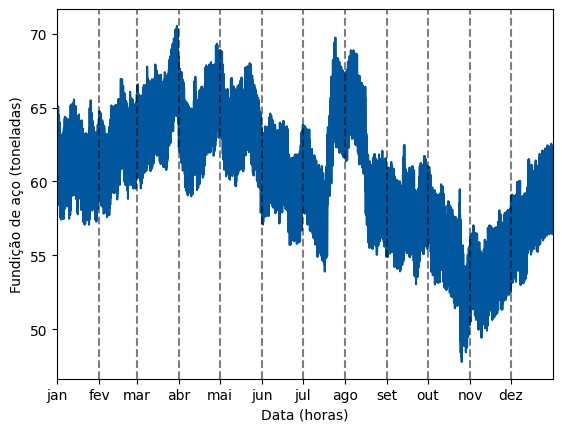

In [137]:
# Ajustar meus números aleatórios com base no comprimento do vetor de datas

# Extraindo o número de linhas/número de datas
n = df.shape[0]

# Definindo a atividade máxima e mínima horária
atvMaxH = 1.05*atvMedH
atvMinH = 0.95*atvMedH

# Criando atividade aleatória
atvArray = (atvMaxH - atvMinH)*np.random.rand(n) + atvMinH
df['atividade'] = atvArray

# Criando componente sazonal
#sazonalidade = atvMinH*np.cos((2*np.pi)*(df['Semana']-1)/26)/2
#df['sazonalidade'] = sazonalidade
#print(df)

# Criando componente sazonal
sazonalidade = df_acoes['Porcentagem']/100 + 1
sazonalidade = np.repeat(sazonalidade.values, 24)
df['sazonalidade'] = sazonalidade
print(df)

# Criando atividade real
atvHor = atvArray + atvMedH*(sazonalidade-1)
df['Atividade Horária'] = atvHor

# Configurando o locale para português
locale.setlocale(locale.LC_TIME, 'pt_BR.utf8')

# Criando uma figura com os valores aleatórios
fig, ax= plt.subplots()

ax.plot(df['Data'],df['Atividade Horária'], color = '#00579D', alpha = 1, label = 'Produção horária')
ax.set_xlim(pd.Timestamp('2023-01-01'), pd.Timestamp('2023-12-31 23:00:00'))

# Adicionando linha para cada mês
for date in pd.date_range(start='2023-01-01', end='2023-12-31', freq='MS'):
    ax.axvline(x=date, color='black', linestyle='--', alpha=0.5)

# Configurando o formato do eixo x para mostrar os meses abreviados
ax.xaxis.set_major_locator(mdates.MonthLocator())  # Coloca um marcador em cada mês
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Mostra os três primeiros caracteres do mês

# Definindo o label de cada eixo
ax.set_ylabel('Fundição de aço (toneladas)')
ax.set_xlabel('Data (horas)')

df.to_csv(r"C:\Users\joseh\Documents\GitHub\ENS5173_202401\tabelas\ativWEG.csv")

#### Qual a variabilidade temporal da taxa de atividade?

As taxas foram estimadas para cada hora do ano de 2023, sendo que a componente aleatória foi definida entre 90 e 110% do valor da taxa de atividade média de utilização de tonelada de aço.
Já a componente sazonal foi baseada na variação das ações da empresa, sendo que o primeiro dia foi tratado como 0% e todos os outros dias foram comparados em relação ao primeiro de janeiro.
Nesse sentido, observa-se graficamente que a variação aleatória está em uma escala de aproximadamente 7 toneladas por hora. Além disso, de janeiro até final de março, a produção subiu até chegar ao topo, teve uma queda repentina no começo de abril e assim se mantebe até metade de julho, quando teve uma alta subida de produção até metade de agosto, quando desceu a produção repentinmanete novamente, descendo até final de outubro, tendo uma subida no mês de novembro e dezembro. Percebe-se que se não houvesse o aumento e redução repentinos de produção no mês de julho e agosto, respecticamente, a produção seguiria aproximadamente uma função seno, com alta em final de março e baixa em final de outubro.

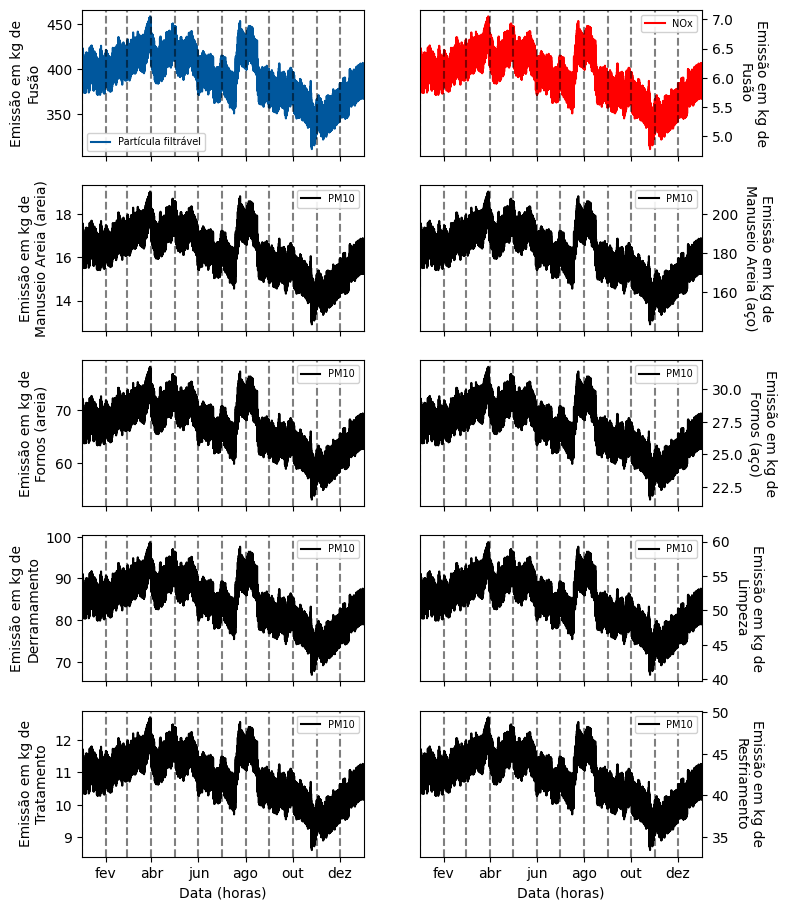

In [138]:
# Criando a figura de emissão de cada processo 

# Subplots com número de linhas e colunas o suficiente para todos os processos
# Sharex significa compartilhar eixo x e sharey significa compartilhar o eixo y
fig,ax = plt.subplots(5,2,sharex=True, figsize=(8,11))
colors = ['#00579D','red','black'] # Definindo as cores de linha para cada poluente
labels = ['Partícula filtrável', 'NOx', 'PM10'] # Apresentando os nomes de cada poluente

i = 0 # Definindo linha 0
j = 0 # Definindo coluna 0

#Loop para preencher o subplot com os gráficos
for k in range(1,4):
    for a in range(9):
        FE = fe.iloc[a, k]
        if not np.isnan(FE):
            ax[i,j].plot(df['Data'],df['Atividade Horária']*FE, color = colors[k-1], alpha=1, label=labels[k-1])
            ax[i,j].set_xlim(pd.Timestamp('2023-01-01'), pd.Timestamp('2023-12-31 23:00:00'))
        
            # Adicionando linha para cada mês
            for date in pd.date_range(start='2023-01-01', end='2023-12-31', freq='MS'):
                ax[i,j].axvline(x=date, color='black', linestyle='--', alpha=0.5)
        
            # Configurando o formato do eixo x para mostrar os meses abreviados
            ax[i,j].xaxis.set_major_locator(mdates.MonthLocator(bymonth=(2, 4, 6, 8, 10, 12)))  # Coloca um marcador em cada mês
            ax[i,j].xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Mostra os três primeiros caracteres do mês
        
            # Criando legenda de acordo com o processo
            leg = ax[i,j].legend(fontsize=7, framealpha=0.9)
        
            # Definindo a posição do label de Data na última linha
            if i == 4:
                ax[i,j].set_xlabel('Data (horas)')

            # Definindo a rotação do label se estiver na coluna da direita para 180 e não definindo se estiver na coluna da esquerda
            # Para evitar texto sobre os gráficos do lado esquerdo, botar eixo y no lado direito dos gráficos da segunda coluna
            if j == 1:
                ax[i,j].set_ylabel('Emissão em kg de\n' + fe['Processo'][a], rotation = 270, labelpad = 25)
                ax[i,j].yaxis.tick_right()
                ax[i,j].yaxis.set_label_position("right")
            else:
                ax[i,j].set_ylabel('Emissão em kg de\n' + fe['Processo'][a])

            # If else para selecionar qual linha e coluna vai ser o próximo gráfico
            if j % 2 == 0:
                j = 1
            else:
                i = i + 1
                j = 0

    # Salva a figura na pasta figures
    fig.savefig(cwd+'\\figures\\emissaoProcessos.png')

6.5
0.1
7.960000000000001


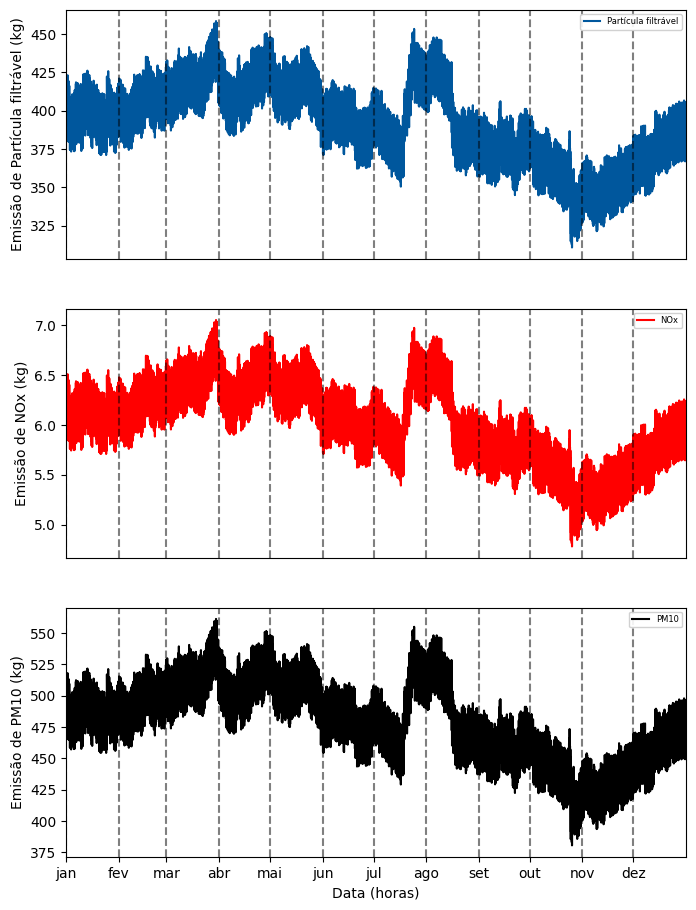

In [139]:
# Criando a figura de emissão para cada poluente

# Subplots com número de linhas e colunas o suficiente para todos os poluente
# Sharex significa compartilhar eixo x
fig,ax = plt.subplots(len(fe.columns)-1,1,sharex=True, figsize=(8,11))

#Loop para preencher o subplot com os gráficos
for ii in range(1,len(fe.columns)):
    # Soma dos fatores de emissão de cada poluente
    SomaFE = (fe.iloc[:,ii]).sum()
    print(SomaFE)

    # Plotando os valores no gráfico
    ax[ii-1].plot(df['Data'],df['Atividade Horária']*SomaFE, color = colors[ii-1], alpha=1, label=labels[ii-1])
    ax[ii-1].set_xlim(pd.Timestamp('2023-01-01'), pd.Timestamp('2023-12-31 23:00:00'))

    # Adicionando linha para cada mês
    for date in pd.date_range(start='2023-01-01', end='2023-12-31', freq='MS'):
        ax[ii-1].axvline(x=date, color='black', linestyle='--', alpha=0.5)

    # Configurando o formato do eixo x para mostrar os meses abreviados
    ax[ii-1].xaxis.set_major_locator(mdates.MonthLocator())  # Coloca um marcador em cada mês
    ax[ii-1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Mostra os três primeiros caracteres do mês

    # Definindo o label de cada eixo
    if ax[2] == ax[ii-1]:
        ax[ii-1].set_xlabel('Data (horas)')
    else: 
        ax[ii-1].xaxis.set_visible(False)
    ax[ii-1].set_ylabel('Emissão de ' + labels[ii-1] + ' (kg)')
    
    # Criando legenda de acordo com o processo
    leg = ax[ii-1].legend(loc='best', fontsize=6, title_fontsize=7, framealpha=0.9)
     
# Salva a figura na pasta figures
fig.savefig(cwd+'\\figures\\emissaoPoluentes.png')

In [140]:
# Qual a soma das emissões considerando todos os processos? 
# Qual a emissão média, mínima e máxima (unidades sempre em gramas por segundo - g/s)

df['Atividade em kg/s'] = df['Atividade Horária']*1000/3600

# Cálcula emissões para cada poluente
for ii in range(1,len(fe.columns)):
    # Somando os fatores de emissão de cada processo para um poluente
    SomaFE = (fe.iloc[:,ii]).sum()

    # Encontrando o menor, maior e médio valor de emissão, fazendo conversão de kg/h para g/s com a multiplicação de 1000/3600, e apresentando apenas 2 algarismos após o ponto
    emissSoma = round(df['Atividade Horária'].sum() * SomaFE, 2)
    emissMenor = round(df['Atividade em kg/s'].min() * SomaFE, 2)
    emissMaior = round(df['Atividade em kg/s'].max() * SomaFE, 2)
    emissMedia = round(df['Atividade em kg/s'].mean() * SomaFE, 2)

    # Apresentando a quantidade de valores de emissão para cada poluente
    print('A soma das emissões de ' + labels[ii-1] + ' foi de ' + str(emissSoma) + ' kg')
    print('A emissão mínima de ' + labels[ii-1] + ' foi de ' + str(emissMenor) + ' g/s')
    print('A emissão média de ' + labels[ii-1] + ' foi de ' + str(emissMedia) + ' g/s')
    print('A emissão máxima de ' + labels[ii-1] + ' foi de ' + str(emissMaior) + ' g/s')
    print('')
    
    df['Emissão de ' +  labels[ii-1] + ' em g/s'] = df['Atividade em kg/s']*SomaFE

print(df)
df.to_csv(r"C:\Users\joseh\Documents\GitHub\ENS5173_202401\tabelas\ativWEG.csv")

A soma das emissões de Partícula filtrável foi de 3430291.98 kg
A emissão mínima de Partícula filtrável foi de 86.32 g/s
A emissão média de Partícula filtrável foi de 108.77 g/s
A emissão máxima de Partícula filtrável foi de 127.32 g/s

A soma das emissões de NOx foi de 52773.72 kg
A emissão mínima de NOx foi de 1.33 g/s
A emissão média de NOx foi de 1.67 g/s
A emissão máxima de NOx foi de 1.96 g/s

A soma das emissões de PM10 foi de 4200788.33 kg
A emissão mínima de PM10 foi de 105.7 g/s
A emissão média de PM10 foi de 133.21 g/s
A emissão máxima de PM10 foi de 155.91 g/s

                    Data  Mes  Semana  atividade  sazonalidade  \
0    2023-01-01 00:00:00    1       1  59.695113        1.0000   
1    2023-01-01 01:00:00    1       1  62.312443        1.0000   
2    2023-01-01 02:00:00    1       1  59.405557        1.0000   
3    2023-01-01 03:00:00    1       1  63.814839        1.0000   
4    2023-01-01 04:00:00    1       1  61.132948        1.0000   
...                  ...